<a href="https://colab.research.google.com/github/nastaranmarzban/BGAT-and-GAT-Jupyter-notebook/blob/main/BGAT_5classes_150nodes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Mount to gdrive to read data, adjacency matrix, p_link and labels.

In [ ]:
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


# Install pandas to read csv files from gdrive. Install torch and numpy which are packages that are needed durind coding.

In [ ]:
!pip install pandas
import pandas as pd
import torch
import numpy as np

# Load data which are processed in preprocessing_data_7classes.ipynb file.

In [ ]:
path = F"/gdrive/MyDrive/5classes_150.sim/data.pt"
Data = torch.load(path)
Data

{'x': tensor([[-1.1996, -0.5363, -1.0551,  ...,  1.0784, -0.1099,  0.6258],
         [ 1.9717,  1.5424,  1.0104,  ..., -0.6536,  2.3499, -0.1438],
         [-0.3870,  0.3711, -1.0519,  ..., -0.6554,  2.1013, -0.8379],
         ...,
         [-1.4236, -1.3652, -1.1248,  ..., -1.0004,  0.0174,  1.6165],
         [-0.5597, -2.0122,  0.3641,  ...,  0.2956, -0.0478, -0.5333],
         [ 0.5681, -0.7714,  0.7749,  ..., -0.5489, -1.6281,  1.2040]]),
 'edge_index': tensor([[  0,   0,   0,  ..., 149, 149, 149],
         [ 21,  57,  97,  ..., 109, 128, 141]]),
 'y': tensor([2, 1, 3, 4, 4, 1, 0, 4, 4, 2, 4, 3, 1, 0, 2, 4, 2, 1, 3, 0, 0, 1, 2, 1,
         1, 2, 3, 0, 2, 4, 2, 1, 0, 0, 0, 3, 0, 0, 1, 1, 3, 0, 0, 1, 1, 4, 4, 1,
         3, 4, 0, 4, 3, 3, 3, 3, 4, 2, 2, 2, 4, 4, 3, 2, 1, 3, 3, 0, 3, 0, 4, 4,
         0, 0, 1, 2, 4, 1, 0, 4, 1, 3, 2, 0, 0, 4, 1, 3, 0, 4, 2, 2, 3, 2, 4, 3,
         3, 2, 1, 4, 4, 2, 4, 2, 0, 0, 4, 2, 3, 0, 0, 3, 1, 4, 3, 1, 1, 1, 1, 3,
         2, 1, 2, 4, 1, 0, 1, 3, 

# Gather some statistics about the graph.

In [ ]:
print(f'Number of nodes: {Data["x"].size(0)}')
print(f'Number of features: {Data["x"].size(1)}')
print(f'Number of classes: {torch.numel(torch.unique(Data["y"],sorted=True))}')
print(f'Number of edges: {Data["edge_index"].size(1)}')
print(f'Average node degree: {Data["edge_index"].size(1) / Data["x"].size(0):.2f}')
print(f'Number of training nodes: {Data["train_mask"].sum()}')
print(f'Number of testing nodes: {Data["test_mask"].sum()}')
print(f'Training node label rate: {int(Data["train_mask"].sum()) /  Data["x"].size(0):.2f}')

Number of nodes: 150
Number of features: 500
Number of classes: 5
Number of edges: 954
Average node degree: 6.36
Number of training nodes: 120
Number of testing nodes: 15
Training node label rate: 0.80


# Read p_link from gdrive to use it as the attention.

In [ ]:
path = F"/gdrive/MyDrive/5classes_150.sim/p_link.pt"
p_link = torch.load(path)
print(p_link.size())
print(p_link.dtype)
print(p_link.type())

torch.Size([150, 150])
torch.float32
torch.FloatTensor


# Install torch_geometic.

In [ ]:
import os
os.environ['TORCH'] = torch.__version__
print(torch.__version__)

!pip install -q torch-scatter -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q torch-sparse -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q git+https://github.com/pyg-team/pytorch_geometric.git

2.1.0+cu118
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.2/10.2 MB 35.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 14.2 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


# Developing my own model (making our own message passing layers), which name is BGAT.

**BGATConv**
$$ X^\prime _i = \sum_{j \in N(i)\cup i} \alpha_{ij}\Theta X_j$$
In which $\alpha$s are computed via BDgraph (p_link) and $\Theta$ is learnable parameter

In [ ]:
from torch_geometric.nn import MessagePassing
import torch_geometric.nn
import torch.nn.functional as F
from torch_geometric.utils import add_self_loops

# Creating message passing network.

In [ ]:
class BGATConv(MessagePassing):
    def __init__(
        self,
        in_channels,
        out_channels,
        **kwargs,
    ):
        kwargs.setdefault('aggr', 'add')
        super().__init__(node_dim = 0, **kwargs)
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.lin = torch.nn.Linear(in_channels, out_channels)

    def forward(self, x, edge_index):
        edge_index, _ = add_self_loops(Data["edge_index"], num_nodes = Data["x"].size(0))
        x = self.lin(x)
        atten = p_link
        return self.propagate(edge_index, x=x, atten = atten)

    def message(self, x_j, atten, edge_index_i, edge_index_j):
        return atten[edge_index_i, edge_index_j].reshape(-1,1) * x_j

    def __repr__(self):
        return '{}({}, {})'.format(self.__class__.__name__, self.in_channels, self.out_channels)

# Make GNN layers with our own model, BGAT. We use three BGAT conv

In [ ]:
class Myconv(torch.nn.Module):
    def __init__(self):
        super().__init__()
        torch.manual_seed(2)
        self.conv1 = BGATConv(in_channels = 500, out_channels = 7)
        self.conv2 =  BGATConv(7, 5)


    def forward(self, x, edge_index):
        h = self.conv1(x, edge_index)
        h = F.torch.tanh(h)
        h = self.conv2(h, edge_index)
        return h

model = Myconv()
print(model)
print(model.forward(Data["x"], Data["edge_index"]))

Myconv(
  (conv1): BGATConv(500, 7)
  (conv2): BGATConv(7, 5)
)
tensor([[ 1.5747e+00,  1.6276e-01, -5.9854e-02,  6.2066e-01,  1.8008e-01],
        [ 3.3387e+00, -3.7619e+00,  1.3379e+00,  4.0181e-01, -4.7789e+00],
        [-5.0024e-01, -1.1075e+00, -1.2383e+00,  2.2114e+00, -1.2564e+00],
        [-3.0328e-01, -4.4268e-01, -3.9769e-01,  3.3618e+00,  7.2928e-01],
        [ 2.2614e+00, -9.7887e-01, -1.3257e-03,  6.0135e-01,  2.0692e-01],
        [ 6.1851e+00, -3.2715e+00,  1.7243e+00, -4.4195e-01, -4.6266e+00],
        [ 6.6987e+00,  3.2991e-01, -2.4755e+00,  3.2885e+00, -1.5619e+00],
        [-7.7724e-01,  7.9944e-02, -5.7655e-01,  1.3206e-01, -6.1286e-01],
        [-2.5452e+00, -1.0275e-01, -4.4038e-01,  3.3876e+00, -1.1169e+00],
        [ 1.5450e+00, -1.7516e+00, -1.6505e+00,  3.0160e+00, -9.0901e-01],
        [ 1.9426e+00, -1.6184e+00, -1.5471e+00,  4.2116e-02,  2.5391e-01],
        [ 3.0346e-02, -1.0381e+00, -1.9407e+00,  2.4746e+00, -1.0803e+00],
        [ 4.3604e+00, -3.7654e+00,  

# We take a look at the node embeddings produced by our GNN (before training).

In [ ]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import seaborn as sns

def visualize(h):
    z = TSNE(n_components = 2, random_state = 0).fit_transform(h.detach().numpy())
    plt.figure(figsize = (6,4),  dpi = 120)
    sns.scatterplot(x = z[:, 0], y = z[:, 1], hue = Data["y"], palette=sns.color_palette("bright",7)).set(title = "Second scenario data T-SNE projection before training (BGAT)")

Here, we pass in the initial node features x and the graph connectivity information edge_index to the model, and visualize its 2-dimensional embedding.

Embedding shape: [150, 5]


<ipython-input-76-8bde51ee94e9>:8: UserWarning: The palette list has more values (7) than needed (5), which may not be intended.
  sns.scatterplot(x = z[:, 0], y = z[:, 1], hue = Data["y"], palette=sns.color_palette("bright",7)).set(title = "Second scenario data T-SNE projection before training (BGAT)")


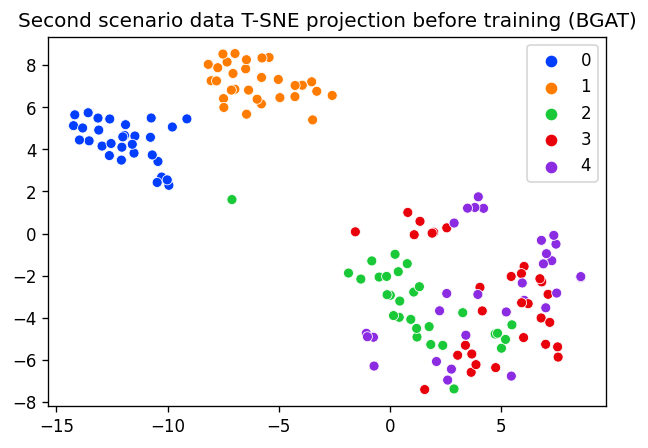

In [ ]:
model = Myconv()
h = model(Data["x"], Data["edge_index"])

print(f'Embedding shape: {list(h.shape)}')
visualize(h)

# Start training the model.

In [ ]:
model = Myconv()
criterion = torch.nn.CrossEntropyLoss()  # Define loss criterion.
optimizer = torch.optim.Adam(model.parameters(),  lr = 0.0005)  # Define optimizer, an object for updating parameters
#loss = loss + weight decay parameter * L2 norm of the weights, 1) To prevent overfitting 2) To keep the weights small and avoid exploding gradient

def train(Data):
    model.train()
    optimizer.zero_grad()  # Clear gradients.
    out = model(Data["x"], Data["edge_index"])
    train_loss = criterion(out[Data["train_mask"]], Data["y"][Data["train_mask"]])  # Compute the loss solely based on the training nodes.
    train_loss.backward()  # Derive gradients.
    optimizer.step()  # Update parameters based on gradients.
    return train_loss


def val(Data):
      model.eval()
      with torch.no_grad():
        out = model(Data["x"], Data["edge_index"])
        val_loss = criterion(out[Data["val_mask"]], Data["y"][Data["val_mask"]])
        #pred = out.argmax(dim=1)
        #test_correct = pred[Data["val_mask"]] == Data["y"][Data["val_mask"]]  # Check against ground-truth labels.
        #test_acc = int(test_correct.sum()) / int(Data["val_mask"].sum())  # Derive ratio of correct predictions.
        return val_loss

In [ ]:
train_loss_ = []
val_loss_ = []

for epoch in range(1, 37):

  epoch_train_loss = []
  epoch_val_loss = []
  train_loss = train(Data)
  val_loss = val(Data)






  epoch_train_loss.append(train_loss.item())
  epoch_val_loss.append(val_loss.item())






  val_loss_.append(sum(epoch_val_loss)/len(epoch_val_loss))
  train_loss_.append(sum(epoch_train_loss)/len(epoch_train_loss))
  print(epoch,'Train Loss: %.3f | val Loss: %.3f'%( train_loss,val_loss))

1 Train Loss: 3.753 | val Loss: 2.949
2 Train Loss: 2.721 | val Loss: 1.958
3 Train Loss: 1.718 | val Loss: 1.448
4 Train Loss: 1.204 | val Loss: 1.174
5 Train Loss: 0.935 | val Loss: 1.002
6 Train Loss: 0.811 | val Loss: 0.886
7 Train Loss: 0.754 | val Loss: 0.800
8 Train Loss: 0.715 | val Loss: 0.733
9 Train Loss: 0.683 | val Loss: 0.679
10 Train Loss: 0.656 | val Loss: 0.634
11 Train Loss: 0.632 | val Loss: 0.597
12 Train Loss: 0.610 | val Loss: 0.564
13 Train Loss: 0.590 | val Loss: 0.536
14 Train Loss: 0.571 | val Loss: 0.510
15 Train Loss: 0.553 | val Loss: 0.488
16 Train Loss: 0.535 | val Loss: 0.467
17 Train Loss: 0.518 | val Loss: 0.448
18 Train Loss: 0.501 | val Loss: 0.432
19 Train Loss: 0.485 | val Loss: 0.417
20 Train Loss: 0.470 | val Loss: 0.403
21 Train Loss: 0.455 | val Loss: 0.391
22 Train Loss: 0.440 | val Loss: 0.381
23 Train Loss: 0.426 | val Loss: 0.371
24 Train Loss: 0.413 | val Loss: 0.363
25 Train Loss: 0.400 | val Loss: 0.355
26 Train Loss: 0.387 | val Loss: 0

# Visualize train loss and val loss.

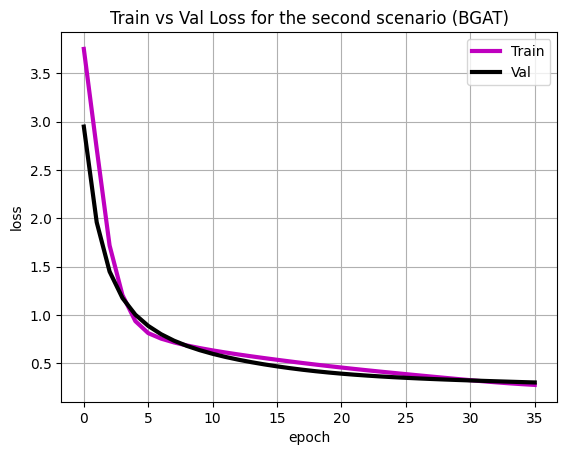

In [ ]:
plt.plot(train_loss_, "m", linewidth = 3)
plt.plot(val_loss_, "k", linewidth = 3)
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['Train','Val'])
plt.title('Train vs Val Loss for the second scenario (BGAT)')
plt.grid()
plt.show()

# Compute the accuracy of the model.

In [ ]:
def test(Data):
      model.eval()
      with torch.no_grad():
        out = model(Data["x"], Data["edge_index"])
        pred = out.argmax(dim=1)
        test_correct = pred[Data["test_mask"]] == Data["y"][Data["test_mask"]]  # Check against ground-truth labels.
        test_acc = int(test_correct.sum()) / int(Data["test_mask"].sum())  # Derive ratio of correct predictions.
        return test_acc

In [ ]:
test_acc = test(Data)
print(f'Test Accuracy: {100*test_acc:.2f}')

Test Accuracy: 93.33


# We take a look at the node embeddings produced by our GNN (after training).

In [ ]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import seaborn as sns

def visualize(h):
    z = TSNE(n_components = 2, random_state = 0).fit_transform(h.detach().numpy())
    plt.figure(figsize = (6,4),  dpi = 120)
    sns.scatterplot(x = z[:, 0], y = z[:, 1], hue = Data["y"], palette=sns.color_palette("bright",7)).set(title = "Second scenario T-SNE projection after training (BGAT)")

<ipython-input-83-2c9b43446779>:8: UserWarning: The palette list has more values (7) than needed (5), which may not be intended.
  sns.scatterplot(x = z[:, 0], y = z[:, 1], hue = Data["y"], palette=sns.color_palette("bright",7)).set(title = "Second scenario T-SNE projection after training (BGAT)")


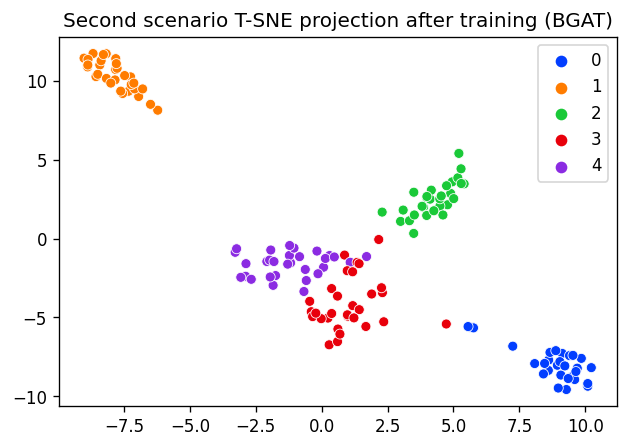

In [ ]:
model.eval()
out = model(Data["x"], Data["edge_index"])
visualize(out)

# Confusion matrix.

In [ ]:
pred_t = out.argmax(dim=1)
pred_t

tensor([2, 1, 3, 4, 4, 1, 0, 4, 4, 2, 4, 3, 1, 0, 2, 4, 2, 1, 3, 0, 0, 1, 2, 1,
        1, 2, 3, 0, 2, 4, 2, 1, 0, 0, 0, 2, 0, 0, 1, 1, 3, 0, 0, 1, 1, 4, 4, 1,
        3, 4, 0, 2, 3, 3, 3, 3, 4, 2, 2, 2, 0, 4, 3, 2, 1, 3, 3, 0, 3, 0, 4, 4,
        0, 0, 1, 2, 4, 1, 0, 4, 1, 3, 2, 0, 0, 3, 1, 3, 0, 4, 2, 2, 3, 2, 3, 0,
        3, 2, 1, 4, 4, 2, 1, 2, 0, 0, 4, 2, 3, 0, 0, 3, 1, 4, 3, 1, 1, 1, 1, 3,
        2, 1, 2, 4, 1, 0, 1, 2, 0, 2, 1, 3, 3, 2, 2, 4, 3, 4, 2, 3, 0, 0, 2, 3,
        1, 1, 2, 2, 3, 0])

In [ ]:
Data["y"]

tensor([2, 1, 3, 4, 4, 1, 0, 4, 4, 2, 4, 3, 1, 0, 2, 4, 2, 1, 3, 0, 0, 1, 2, 1,
        1, 2, 3, 0, 2, 4, 2, 1, 0, 0, 0, 3, 0, 0, 1, 1, 3, 0, 0, 1, 1, 4, 4, 1,
        3, 4, 0, 4, 3, 3, 3, 3, 4, 2, 2, 2, 4, 4, 3, 2, 1, 3, 3, 0, 3, 0, 4, 4,
        0, 0, 1, 2, 4, 1, 0, 4, 1, 3, 2, 0, 0, 4, 1, 3, 0, 4, 2, 2, 3, 2, 4, 3,
        3, 2, 1, 4, 4, 2, 4, 2, 0, 0, 4, 2, 3, 0, 0, 3, 1, 4, 3, 1, 1, 1, 1, 3,
        2, 1, 2, 4, 1, 0, 1, 3, 0, 2, 1, 3, 3, 2, 2, 4, 3, 4, 2, 3, 0, 0, 2, 3,
        1, 1, 2, 2, 4, 0])

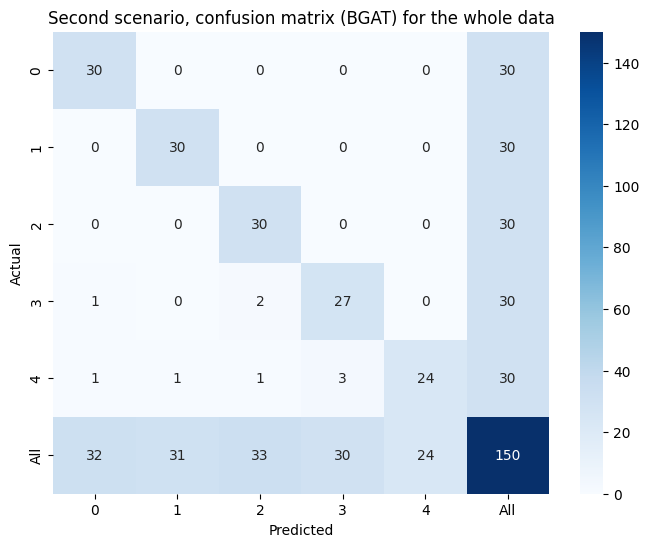

In [ ]:
import seaborn as sn
confusion_matrix = pd.crosstab(Data['y'], pred_t, rownames=['Actual'], colnames = ['Predicted'], margins = True)
plt.figure(figsize=(8, 6))
sn.heatmap(confusion_matrix, annot=True,  cmap="Blues", fmt='g')
plt.title('Second scenario, confusion matrix (BGAT) for the whole data')
plt.show()

In [ ]:
pred = pred_t[Data["test_mask"]]

In [ ]:
act = Data["y"][Data["test_mask"]]

In [ ]:
data = {'y_Actual':    act,
        'y_Predicted':pred
        }

df = pd.DataFrame(data, columns = ['y_Actual','y_Predicted'])
df

,y_Actual,y_Predicted
0,1,1
1,2,2
2,2,2
3,3,2
4,4,4
5,0,0
6,2,2
7,4,4
8,0,0
9,4,4


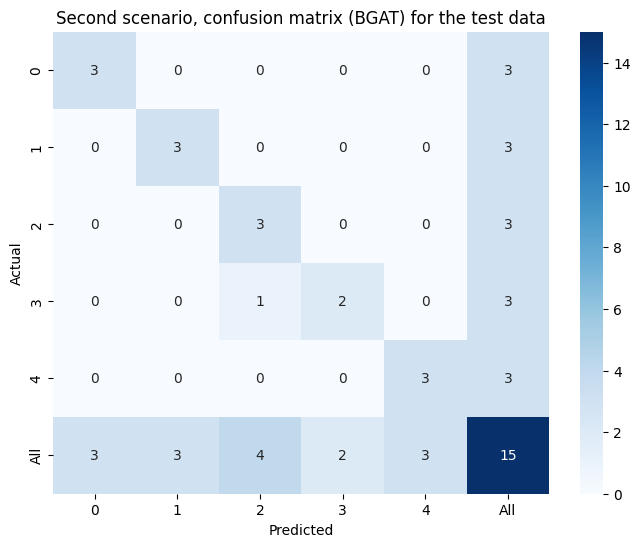

In [ ]:
import seaborn as sn
confusion_matrix = pd.crosstab(act, pred, rownames=['Actual'], colnames = ['Predicted'], margins = True)
plt.figure(figsize=(8, 6))
sn.heatmap(confusion_matrix, annot=True,  cmap="Blues", fmt='g')
plt.title('Second scenario, confusion matrix (BGAT) for the test data')
plt.show()